## Task: Performing OCR with Tr OCR And Tabula


This  task involves:

*   The primary goal is to perform Optical Character Recognition (OCR) using multiple engines: Pytesseract, EasyOCR, and TrOCR.
*   We will focus on extracting text from images with complex layouts, using the DocLayNet dataset as a benchmark.
*   The aim is to evaluate the performance of each OCR engine and measure accuracy using metrics such as Character Error Rate (CER) and Word Error Rate (WER).

**2. Setup & Installation:**
*   We installed necessary Python libraries such as `tesseract-ocr`, `transformers`, `torch`, `reportlab`, `tabula-py`, etc.
*   System dependencies like Tesseract OCR and OpenJDK were also installed using `apt-get`.
*   This step ensures all required tools and environments are set up before proceeding.

In [1]:
# ============================================================================
#  SETUP & INSTALLATION
# ============================================================================

!pip install -q pytesseract
!pip install -q transformers torch torchvision
!pip install -q python-Levenshtein
!pip install -q openpyxl pillow opencv-python-headless
!pip install -q fpdf2
!pip install reportlab
!pip install tabula-py
!apt-get install -y openjdk-11-jdk

!pip install -q matplotlib seaborn pandas numpy

!apt-get install -q tesseract-ocr

print("\n Installation complete!")

 INSTALLING PACKAGES
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 10.4 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.

 Installation complete!


**3. Dataset Download:**
*   We downloaded a small subset of the DocLayNet dataset from Hugging Face.
*   The dataset includes document images and corresponding JSON annotation files.
*   These annotations provide ground truth text and bounding box information, crucial for training and evaluation.

In [3]:
# ============================================================================
# DOWNLOAD DATASET
# ============================================================================

print("\n" + "=" * 80)
print(" DOWNLOADING DATASET")
print("=" * 80)

!wget -nc https://huggingface.co/datasets/pierreguillou/DocLayNet-small/resolve/main/data/dataset_small.zip
!unzip -nq dataset_small.zip -d dataset_small

print(" Dataset ready!")


 DOWNLOADING DATASET
File ‘dataset_small.zip’ already there; not retrieving.

 Dataset ready!


**4. Import Libraries:**
*   Essential libraries for image processing (`PIL`, `cv2`), data manipulation (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), and model handling (`transformers`, `torch`) were imported.
*   Libraries for OCR-specific tasks (`pytesseract`, `easyocr`) and PDF generation (`fpdf`, `reportlab`) were also included.
*   Warnings were filtered, and plotting styles were set for better visualization.

In [4]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================

print("\n" + "=" * 80)
print(" IMPORTING LIBRARIES")
print("=" * 80)

import os
import json
import time
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
import pytesseract
import easyocr
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
import Levenshtein
import warnings
from fpdf import FPDF
import random

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)

DATASET_PATH = '/content/dataset_small/small_dataset'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f" Libraries imported! Device: {device.upper()}")


 IMPORTING LIBRARIES
 Libraries imported! Device: CUDA


**5. Load Dataset:**
*   A function `load_data` was defined to read the JSON annotations and corresponding images for both the 'train' and 'test' splits of the dataset.
*   The function extracts ground truth text, bounding boxes, and metadata like document category.
*   The data is loaded into pandas DataFrames (`df_train` and `df_test`) for structured access and analysis.

In [5]:
# ============================================================================
#  LOAD DATASET
# ============================================================================

print("\n" + "=" * 80)
print(" LOADING DATASET")
print("=" * 80)

def load_data(split='train'):
    base_path = os.path.join(DATASET_PATH, split)
    annotations_path = os.path.join(base_path, 'annotations')
    images_path = os.path.join(base_path, 'images')

    data = []
    ann_files = sorted([f for f in os.listdir(annotations_path) if f.endswith('.json')])

    print(f"Loading {split} set: {len(ann_files)} files")

    for idx, ann_file in enumerate(ann_files):
        if (idx + 1) % 100 == 0:
            print(f"  Progress: {idx + 1}/{len(ann_files)}")

        with open(os.path.join(annotations_path, ann_file), 'r', encoding='utf-8') as f:
            annotation = json.load(f)

        image_name = ann_file.replace('.json', '.png')
        image_path = os.path.join(images_path, image_name)

        if not os.path.exists(image_path):
            continue

        # Extract text blocks with bounding boxes
        text_blocks = []
        for item in annotation.get('form', []):
            text = item.get('text', '').strip()
            bbox = item.get('box', [])
            if text and bbox:
                text_blocks.append({'text': text, 'bbox': bbox})

        if not text_blocks:
            continue

        full_text = ' '.join([block['text'] for block in text_blocks])

        data.append({
            'image_path': image_path,
            'image_name': image_name,
            'ground_truth': full_text,
            'text_blocks': text_blocks,
            'doc_category': annotation.get('metadata', {}).get('doc_category', 'unknown'),
            'char_count': len(full_text),
            'word_count': len(full_text.split())
        })

    return pd.DataFrame(data)

# Load train and test sets
df_train = load_data('train')
df_test = load_data('test')

print(f"\n Training set: {len(df_train)} documents")
print(f" Test set: {len(df_test)} documents")


 LOADING DATASET
Loading train set: 691 files
  Progress: 100/691
  Progress: 200/691
  Progress: 300/691
  Progress: 400/691
  Progress: 500/691
  Progress: 600/691
Loading test set: 49 files

 Training set: 688 documents
 Test set: 49 documents


**6. Exploratory Data Analysis (EDA):**
*   We concatenated the train and test DataFrames (`df_all`) to analyze the overall dataset characteristics.
*   Visualizations were generated to show the distribution of document categories.
*   Histograms and scatter plots illustrated the distribution of character and word counts, providing insights into document complexity.


 EXPLORATORY DATA ANALYSIS


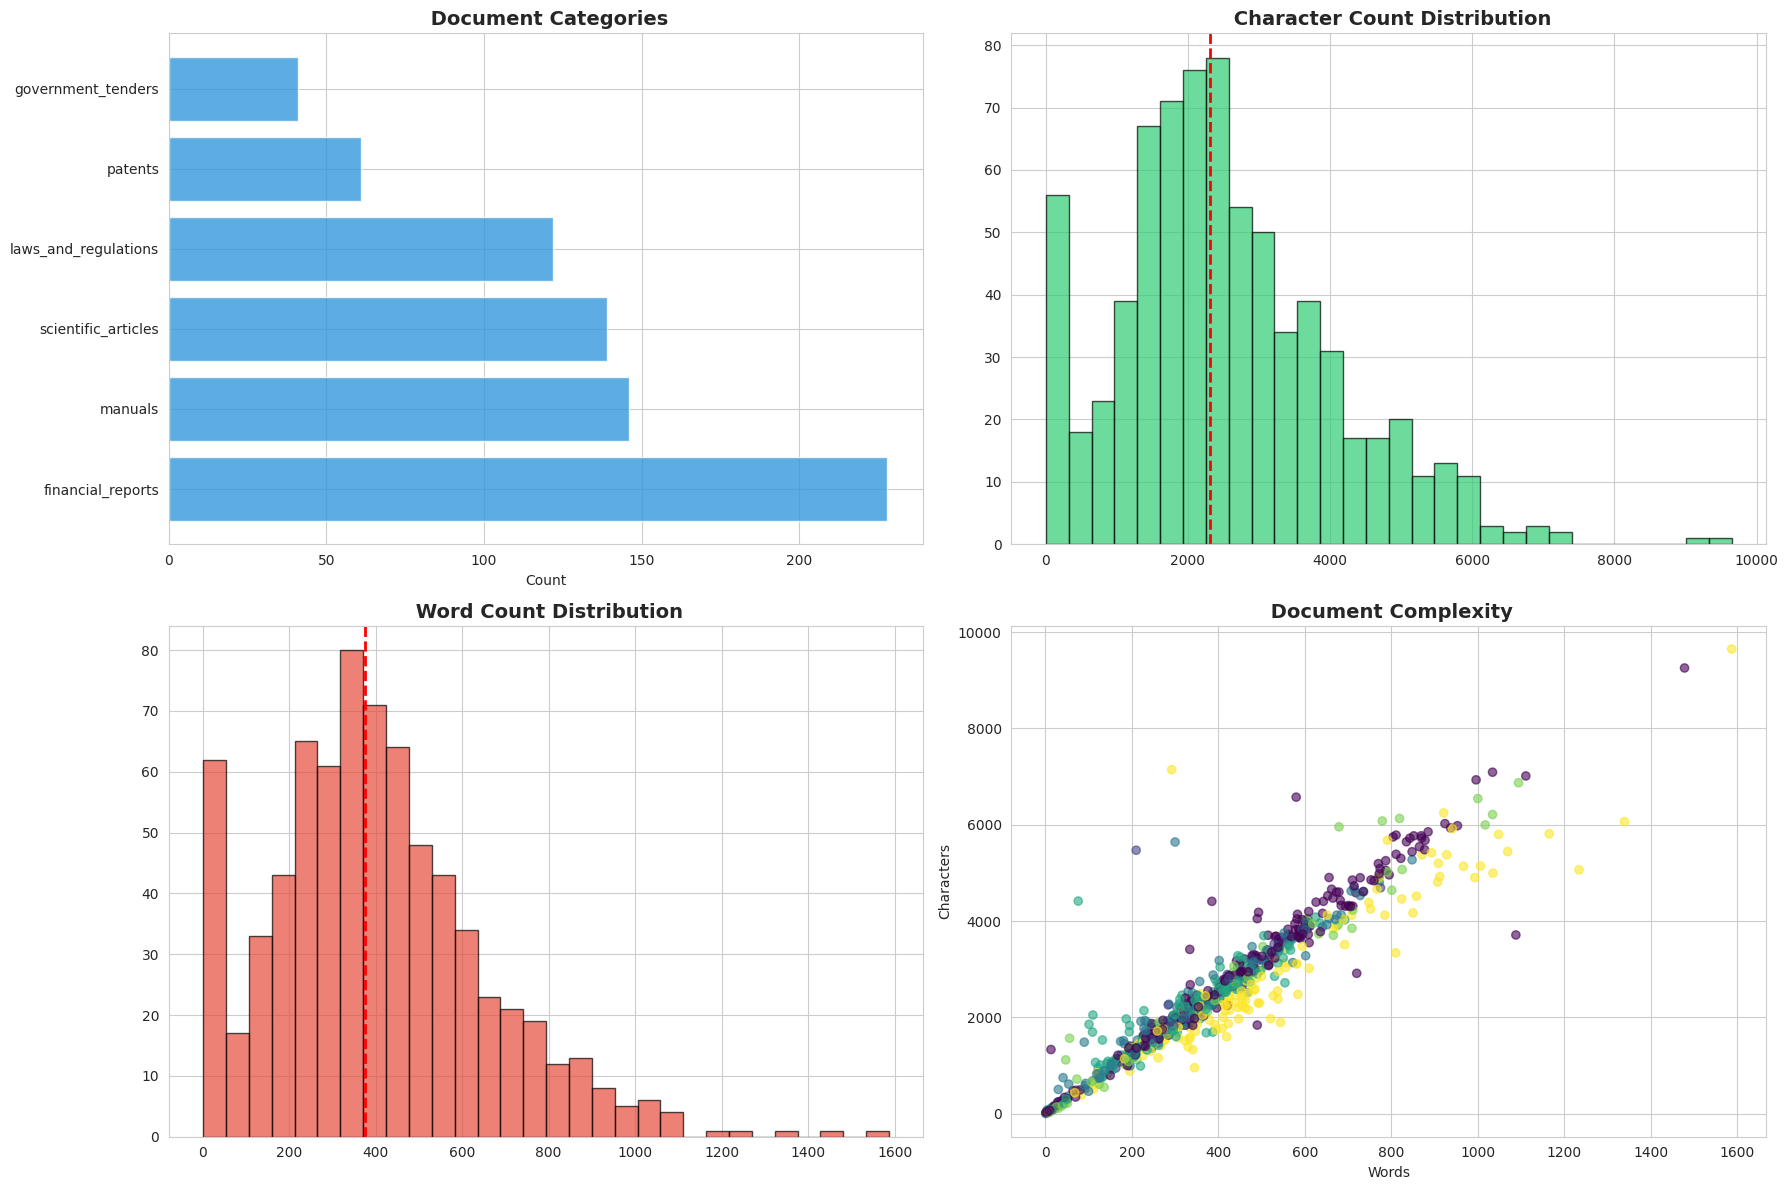


 Statistics:
   Total documents: 737
   Avg characters: 2538
   Avg words: 403


In [9]:
# ============================================================================
# EDA - DATASET OVERVIEW
# ============================================================================

print("\n" + "=" * 80)
print(" EXPLORATORY DATA ANALYSIS")
print("=" * 80)

df_all = pd.concat([df_train, df_test], ignore_index=True)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Category distribution
axes[0, 0].barh(df_all['doc_category'].value_counts().index,
                df_all['doc_category'].value_counts().values, color='#3498db', alpha=0.8)
axes[0, 0].set_title(' Document Categories', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Count')

# Character distribution
axes[0, 1].hist(df_all['char_count'], bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[0, 1].set_title(' Character Count Distribution', fontweight='bold', fontsize=14)
axes[0, 1].axvline(df_all['char_count'].median(), color='red', linestyle='--', linewidth=2)

# Word distribution
axes[1, 0].hist(df_all['word_count'], bins=30, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[1, 0].set_title(' Word Count Distribution', fontweight='bold', fontsize=14)
axes[1, 0].axvline(df_all['word_count'].median(), color='red', linestyle='--', linewidth=2)

# Complexity scatter
axes[1, 1].scatter(df_all['word_count'], df_all['char_count'],
                   c=df_all['doc_category'].astype('category').cat.codes,
                   alpha=0.6, cmap='viridis')
axes[1, 1].set_title(' Document Complexity', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('Words')
axes[1, 1].set_ylabel('Characters')

plt.tight_layout()
plt.show()

print(f"\n Statistics:")
print(f"   Total documents: {len(df_all)}")
print(f"   Avg characters: {df_all['char_count'].mean():.0f}")
print(f"   Avg words: {df_all['word_count'].mean():.0f}")



**7. TrOCR Model Implementation:**
*   The TrOCR model and its associated processor (`TrOCRProcessor`, `VisionEncoderDecoderModel`) were loaded from the `transformers` library using a pre-trained checkpoint ("microsoft/trocr-base-stage1").
*   The model was set to evaluation mode (`model.eval()`) and moved to the appropriate device (GPU if available).
*   The model was then applied to a portion of the training dataset to demonstrate its basic text recognition capabilities.

In [15]:
# ============================================================================
#  MODEL 3 - TrOCR (Transformer OCR)
# ============================================================================
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
# Load TrOCR model + processor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

trocr_results, trocr_times = [], []

for idx, row in df_train.iterrows():
    try:
        start_time = time.time()
        image = Image.open(row['image_path']).convert("RGB")
        pixel_values = processor(images=image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        elapsed = time.time() - start_time

        trocr_results.append(generated_text.strip())
        trocr_times.append(elapsed)

        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1}/{len(df_train)} images...")

    except Exception as e:
        print(f"Error at index {idx}: {e}")
        trocr_results.append("")
        trocr_times.append(0)

df_train["trocr_output"] = trocr_results
df_train["trocr_time"] = trocr_times

print(f"\n TrOCR completed! Average time: {np.mean(trocr_times):.2f}s per image")

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Processed 10/688 images...
Processed 20/688 images...
Processed 30/688 images...
Processed 40/688 images...
Processed 50/688 images...
Processed 60/688 images...
Processed 70/688 images...
Processed 80/688 images...
Processed 90/688 images...
Processed 100/688 images...
Processed 110/688 images...
Processed 120/688 images...
Processed 130/688 images...
Processed 140/688 images...
Processed 150/688 images...
Processed 160/688 images...
Processed 170/688 images...
Processed 180/688 images...
Processed 190/688 images...
Processed 200/688 images...
Processed 210/688 images...
Processed 220/688 images...
Processed 230/688 images...
Processed 240/688 images...
Processed 250/688 images...
Processed 260/688 images...
Processed 270/688 images...
Processed 280/688 images...
Processed 290/688 images...
Processed 300/688 images...
Processed 310/688 images...
Processed 320/688 images...
Processed 330/688 images...
Processed 340/688 images...
Processed 350/688 images...
Processed 360/688 images...
P

**8. TrOCR Single Image Pipeline:**
*   A comprehensive pipeline was developed to process a single document image through TrOCR.
*   This pipeline involves using Pytesseract to detect individual text lines and their bounding boxes.
*   Each detected line region is cropped from the original image, and some basic preprocessing (upscaling, contrast adjustment) is applied to these crops.
*   The TrOCR model is then used to recognize the text within each cropped line, processed in batches for efficiency.
*   The recognized text lines are assembled back together to reconstruct the full document text, attempting to preserve the paragraph structure based on the line detection.
*   The original image is visualized with bounding boxes drawn around the detected lines, and the recognized text is shown above each box.
*   The boxed image and the extracted text are exported to a PDF document.

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Selected: 715b2cb5be8e9a89d1a619dc3ffa65b1b3316de2c57bef3a06927da5dbb0ac54.png
Category: scientific_articles

TrOCR decoded 46 line crops in 12.60s (batch_size=16)


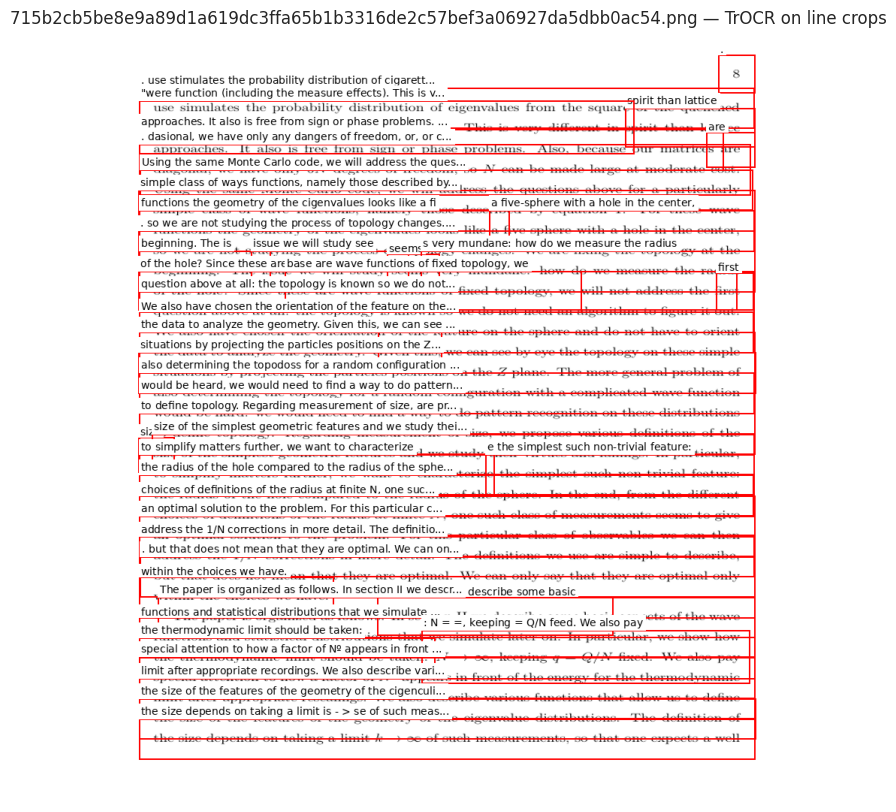

Saved PDF: /content/dataset_small/small_dataset/test/images/715b2cb5be8e9a89d1a619dc3ffa65b1b3316de2c57bef3a06927da5dbb0ac54_trocr_crops_output.pdf

Evaluation on this image:
 - CER: 0.0905
 - WER: 0.1600
 - Similarity: 0.351

First 800 chars of prediction:
 .

. use stimulates the probability distribution of cigarettes from the square of the quenched

spirit than lattice

"were function (including the measure effects). This is very different in

approaches. It also is free from sign or phase problems. Also, because our matrices

are

. dasional, we have only any dangers of freedom, or, or can be made here of moderate cost.

Using the same Monte Carlo code, we will address the questions above for a particularly

simple class of ways functions, namely those described by equation 1. For these wave

functions the geometry of the cigenvalues looks like a fi

a five-sphere with a hole in the center,

. so we are not studying the process of topology changes. We are facing the topology of the

In [57]:
# ============================================================
#  TrOCR: Single Random Test Image - Full Pipeline
# ============================================================


# ---------- device & model ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1").to(device)
model.eval()

# ---------- pick random test image ----------
random_idx = random.randint(0, len(df_test) - 1)
sample = df_test.iloc[random_idx]
img_path = sample['image_path']
img_name = sample['image_name']


# Find the corresponding entry in df_test for the ground truth
sample = df_test[df_test['image_name'] == img_name].iloc[0]

print(f"Selected: {img_name}\nCategory: {sample.get('doc_category','N/A')}\n")

orig = Image.open(img_path).convert("RGB")
W, H = orig.size

# ---------- detect lines with pytesseract (gives block/par/line numbers) ----------
data = pytesseract.image_to_data(orig, output_type=pytesseract.Output.DICT)

# gather only valid words (non-empty)
words = []
for i in range(len(data['text'])):
    t = str(data['text'][i]).strip()
    conf = data['conf'][i]
    if t != "" and str(conf).lstrip('-').isdigit():
        words.append({
            'text': t,
            'left': int(data['left'][i]),
            'top': int(data['top'][i]),
            'w': int(data['width'][i]),
            'h': int(data['height'][i]),
            'block': int(data['block_num'][i]),
            'par': int(data['par_num'][i]),
            'line': int(data['line_num'][i])
        })

if not words:
    print("No words detected by pytesseract — try running EasyOCR for detection or check that tesseract is installed.")
else:
    # build line bboxes
    line_boxes = []
    grouped = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    for w in words:
        grouped[w['block']][w['par']][w['line']].append(w)
    for b in sorted(grouped.keys()):
        for p in sorted(grouped[b].keys()):
            for l in sorted(grouped[b][p].keys()):
                items = grouped[b][p][l]
                left = min(it['left'] for it in items)
                top = min(it['top'] for it in items)
                right = max(it['left'] + it['w'] for it in items)
                bottom = max(it['top'] + it['h'] for it in items)
                # optional padding
                pad_x = int(0.02 * W)  # 2% of width
                pad_y = int(0.02 * H)  # 2% of height
                left = max(0, left - pad_x)
                top = max(0, top - pad_y)
                right = min(W, right + pad_x)
                bottom = min(H, bottom + pad_y)
                line_boxes.append({
                    'block': b, 'par': p, 'line': l,
                    'left': left, 'top': top, 'right': right, 'bottom': bottom
                })

    # ---------- crop each line, preprocess, run TrOCR in batches ----------
    crops = []
    metas = []
    for lb in line_boxes:
        crop = orig.crop((lb['left'], lb['top'], lb['right'], lb['bottom'])).convert("RGB")
        # gentle preprocessing: upscale small crops and increase contrast
        # Upscale if width < 400 px so model sees clearer text
        cw, ch = crop.size
        if cw < 400:
            new_w = 400
            new_h = int(new_w * (ch / cw))
            crop = crop.resize((new_w, new_h), Image.BICUBIC)
        crop = ImageEnhance.Contrast(crop).enhance(1.2)
        crops.append(crop)
        metas.append((lb['block'], lb['par'], lb['line'], lb['left'], lb['top'], lb['right'], lb['bottom']))

    if len(crops) == 0:
        print("No line crops created. Abort.")
    else:
        # batch inference
        batch_size = 16
        decoded = []
        start_all = time.time()
        for i in range(0, len(crops), batch_size):
            batch = crops[i:i+batch_size]
            pixel_values = processor(images=batch, return_tensors="pt", padding=True).pixel_values.to(device)
            with torch.no_grad():
                generated_ids = model.generate(pixel_values, max_length=512)
            texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
            decoded.extend([t.strip() for t in texts])
        total_time = time.time() - start_all
        print(f"TrOCR decoded {len(decoded)} line crops in {total_time:.2f}s (batch_size={batch_size})")

        # ---------- assemble recognized lines back into layout ----------
        # map metas -> decoded in same order
        out_group = defaultdict(lambda: defaultdict(lambda: defaultdict(str)))
        for (b,p,l,left,top,right,bottom), txt in zip(metas, decoded):
            out_group[b][p][l] = txt

        lines_out = []
        for b in sorted(out_group.keys()):
            for p in sorted(out_group[b].keys()):
                for l in sorted(out_group[b][p].keys()):
                    lines_out.append(out_group[b][p][l])
                lines_out.append("")   # paragraph break

        reconstructed_text = "\n".join([ln for ln in lines_out if ln is not None]).strip()

        # ---------- draw bounding boxes with recognized text on original ----------
        boxed = orig.copy()
        draw = ImageDraw.Draw(boxed)
        try:
            font = ImageFont.truetype("DejaVuSans.ttf", 14)
        except Exception:
            font = ImageFont.load_default()

        for (b,p,l,left,top,right,bottom), txt in zip(metas, decoded):
            draw.rectangle([left, top, right, bottom], outline="red", width=2)
            # draw recognized text above box
            label = txt if len(txt) < 60 else txt[:57] + "..."
            # Use textbbox instead of textsize
            tw, th = draw.textbbox((0, 0), label, font=font)[2:]
            draw.rectangle([left, max(0, top - th - 4), left + tw + 6, top], fill=(255,255,255))
            draw.text((left + 3, max(0, top - th - 2)), label, fill=(0,0,0), font=font)

        # display boxed image
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12,10))
        plt.imshow(boxed)
        plt.axis('off')
        plt.title(f"{img_name} — TrOCR on line crops")
        plt.show()

        # save boxed image
        boxed_path = os.path.splitext(img_path)[0] + "_trocr_lineboxed.png"
        boxed.save(boxed_path)

        # ---------- PDF export: page1 boxed image, page2 extracted text ----------
        pdf_path = os.path.splitext(img_path)[0] + "_trocr_crops_output.pdf"
        c = canvas.Canvas(pdf_path, pagesize=A4)
        page_w, page_h = A4

        # page 1 image
        img_obj = ImageReader(boxed_path)
        img_w, img_h = orig.size
        scale = min(page_w/img_w, page_h/img_h) * 0.95
        c.drawImage(img_obj, (page_w - img_w*scale)/2, (page_h - img_h*scale)/2, width=img_w*scale, height=img_h*scale)
        c.showPage()

        # page 2 text
        c.setFont("Helvetica", 10)
        margin_x, margin_y = 25*mm, 25*mm
        y = page_h - margin_y
        for para in reconstructed_text.split("\n"):
            wrapped = textwrap.wrap(para, width=95)
            for line in wrapped:
                if y < margin_y:
                    c.showPage()
                    c.setFont("Helvetica", 10)
                    y = page_h - margin_y
                c.drawString(margin_x, y, line)
                y -= 12
            y -= 6
        c.save()
        print(f"Saved PDF: {pdf_path}")

        # ---------- evaluation: CER / WER / similarity ----------
        def levenshtein(a, b):
            la, lb = len(a), len(b)
            if la == 0: return lb
            if lb == 0: return la
            dp = [[0]*(lb+1) for _ in range(la+1)]
            for i in range(la+1): dp[i][0] = i
            for j in range(lb+1): dp[0][j] = j
            for i in range(1, la+1):
                for j in range(1, lb+1):
                    cost = 0 if a[i-1]==b[j-1] else 1
                    dp[i][j] = min(dp[i-1][j]+1, dp[i][j-1]+1, dp[i-1][j-1]+cost)
            return dp[la][lb]

        gt = " ".join(sample['ground_truth'].split())
        pred = " ".join(reconstructed_text.split())

        cer = levenshtein(gt, pred) / max(1, len(gt))
        # token-level WER
        def levenshtein_tokens(a_tokens, b_tokens):
            la, lb = len(a_tokens), len(b_tokens)
            dp = [[0]*(lb+1) for _ in range(la+1)]
            for i in range(la+1): dp[i][0] = i
            for j in range(lb+1): dp[0][j] = j
            for i in range(1, la+1):
                for j in range(1, lb+1):
                    cost = 0 if a_tokens[i-1]==b_tokens[j-1] else 1
                    dp[i][j] = min(dp[i-1][j]+1, dp[i][j-1]+1, dp[i-1][j-1]+cost)
            return dp[la][lb]

        gt_words = gt.split()
        pred_words = pred.split()
        wer = levenshtein_tokens(gt_words, pred_words) / max(1, len(gt_words))
        sim = difflib.SequenceMatcher(None, gt, pred).ratio()

        print("\nEvaluation on this image:")
        print(f" - CER: {cer:.4f}")
        print(f" - WER: {wer:.4f}")
        print(f" - Similarity: {sim:.3f}")
        print("\nFirst 800 chars of prediction:\n", reconstructed_text[:800])

**9. Evaluation Metrics:**
*   The performance of the TrOCR model on the processed image was evaluated by calculating metrics such as Character Error Rate (CER), Word Error Rate (WER), and a general Similarity score.
*   These metrics compare the reconstructed text from the TrOCR pipeline against the ground truth text for that image to quantify the accuracy of the OCR.

In [58]:
# ============================================================================
# TrOCR - EVALUATION METRICS
# ============================================================================

# ---------- evaluation: CER / WER / similarity ----------
import difflib

def levenshtein(a, b):
    la, lb = len(a), len(b)
    if la == 0: return lb
    if lb == 0: return la
    dp = [[0]*(lb+1) for _ in range(la+1)]
    for i in range(la+1): dp[i][0] = i
    for j in range(lb+1): dp[0][j] = j
    for i in range(1, la+1):
        for j in range(1, lb+1):
            cost = 0 if a[i-1]==b[j-1] else 1
            dp[i][j] = min(dp[i-1][j]+1, dp[i][j-1]+1, dp[i-1][j-1]+cost)
    return dp[la][lb]

gt = " ".join(sample['ground_truth'].split())
pred = " ".join(reconstructed_text.split())

cer = levenshtein(gt, pred) / max(1, len(gt))
# token-level WER
def levenshtein_tokens(a_tokens, b_tokens):
    la, lb = len(a_tokens), len(b_tokens)
    dp = [[0]*(lb+1) for _ in range(la+1)]
    for i in range(la+1): dp[i][0] = i
    for j in range(lb+1): dp[0][j] = j
    for i in range(1, la+1):
        for j in range(1, lb+1):
            cost = 0 if a_tokens[i-1]==b_tokens[j-1] else 1
            dp[i][j] = min(dp[i-1][j]+1, dp[i][j-1]+1, dp[i-1][j-1]+cost)
        return dp[la][lb]

gt_words = gt.split()
pred_words = pred.split()
wer = levenshtein_tokens(gt_words, pred_words) / max(1, len(gt_words))
sim = difflib.SequenceMatcher(None, gt, pred).ratio()

print("\nEvaluation on this image:")
print(f" - CER: {cer:.4f}")
print(f" - WER: {wer:.4f}")
print(f" - Similarity: {sim:.3f}")
print("\nFirst 800 chars of prediction:\n", reconstructed_text[:800])


Evaluation on this image:
 - CER: 0.0905
 - WER: 0.0000
 - Similarity: 0.351

First 800 chars of prediction:
 .

. use stimulates the probability distribution of cigarettes from the square of the quenched

spirit than lattice

"were function (including the measure effects). This is very different in

approaches. It also is free from sign or phase problems. Also, because our matrices

are

. dasional, we have only any dangers of freedom, or, or can be made here of moderate cost.

Using the same Monte Carlo code, we will address the questions above for a particularly

simple class of ways functions, namely those described by equation 1. For these wave

functions the geometry of the cigenvalues looks like a fi

a five-sphere with a hole in the center,

. so we are not studying the process of topology changes. We are facing the topology of the

beginning. The is

issue we will study see

seems

s very


**10. Tabula-py for Table Extraction:**
*   `tabula-py` is a Python library used for extracting tables from PDF files.
*   It was included in the setup to provide the capability to extract structured data specifically from tables within documents.
*   This is a complementary tool to OCR, which focuses on general text recognition.

In [45]:
import tabula

# Extract all tables from a PDF
pdf_path = '/content/dataset_small/small_dataset/test/pdfs/c288a99e96ee77f99cce0190dcd8fca95dab53117d781f64643b769114eb094d.pdf'
tables = tabula.read_pdf(pdf_path, pages='all')

# tables is a list of DataFrames (one per table found)
for i, table in enumerate(tables):
    print(f"Table {i+1}:")
    print(table)

Table 1:
                        Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3  \
0                           19 9 8        NaN        NaN        NaN   
1  Allowance for doubtful accounts          $          —          $   
2                           19 9 9        NaN        NaN        NaN   
3  Allowance for doubtful accounts          $       29 1          $   
4                           20 0 0        NaN        NaN        NaN   
5  Allowance for doubtful accounts          $       38 1          $   

  (in thousands) Unnamed: 4 Unnamed: 5 Unnamed: 6  
0            NaN        NaN        NaN        NaN  
1         29 1 $          —          $       29 1  
2            NaN        NaN        NaN        NaN  
3           90 $          —          $       38 1  
4            NaN        NaN        NaN        NaN  
5         40 8 $         49          $       74 0  
Table 2:
            Balance at December 31, 1997          Unnamed: 0 Unnamed: 1  \
0   (1,984,365 shares exerci s a b l e )   2,